In [1]:
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
import time
from datetime import datetime
import importlib
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import get_loader, image_loader

torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

def str2bool(s):
    if s.lower() == 'true':
        return True
    elif s.lower() == 'false':
        return False
    else:
        raise RuntimeError('Boolean value expected')

In [2]:
zoomlevel = 'zoom13'
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

In [19]:
args = {'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':1,
       'cardinality':1,
       'epochs':200,
       'batch_size':16,
       'base_lr':0.1,
       'weight_decay':0.0005,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[150,225]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('input_shape', (1, 3, 32, 32)),
    ('output_dim', args['output_dim'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

In [4]:
# import network
def load_model(config, model):
    module = importlib.import_module(config['arch'])
    Network = getattr(module, model)
    return Network(config)


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count

In [5]:
def train(epoch, model, optimizer, criterion, train_loader, run_config,
          writer, device):
    global global_step

    logger.info('Train {}'.format(epoch))

    model.train()

    loss_meter = AverageMeter()
    accuracy_meter = AverageMeter()
    start = time.time()

    for step, (_,data) in enumerate(train_loader):
        global_step += 1

        if run_config['tensorboard'] and step == 0:
            image = torchvision.utils.make_grid(
                data, normalize=True, scale_each=True)
            writer.add_image('Train/Image', image, epoch)

        data = data.to(device)
        # targets = targets.to(device)
        optimizer.zero_grad()

        outputs = model(data)
        loss = criterion(outputs, data)
        loss.backward()

        optimizer.step()

        num = data.size(0)

        loss_ = loss.item()
        loss_meter.update(loss_, num)

#         _, preds = torch.max(outputs, dim=1)
#         correct_ = preds.eq(targets).sum().item()
#         accuracy = correct_ / num
#         accuracy_meter.update(accuracy, num)

        if run_config['tensorboard']:
            writer.add_scalar('Train/RunningLoss', loss_, global_step)
#             writer.add_scalar('Train/RunningAccuracy', accuracy, global_step)

#     logger.info('Epoch {} Step {}/{} '
#                 'Loss {:.4f} ({:.4f}) '
#                 'Accuracy {:.4f} ({:.4f})'.format(
#                     epoch,
#                     step,
#                     len(train_loader),
#                     loss_meter.val,
#                     loss_meter.avg,
#                     accuracy_meter.val,
#                     accuracy_meter.avg,
#                 ))
  
    logger.info('Epoch {} Step {}/{} '
                'Train Loss {:.8f} ({:.8f}) '.format(
                    epoch,
                    step,
                    len(train_loader),
                    loss_meter.val,
                    loss_meter.avg
                ))

    if run_config['tensorboard']:
        elapsed = time.time() - start
        writer.add_scalar('Train/Loss', loss_meter.avg, epoch)
#         writer.add_scalar('Train/Accuracy', accuracy_meter.avg, epoch)
        writer.add_scalar('Train/Time', elapsed, epoch)
    
    return loss_meter.avg

In [6]:
def test(epoch, model, criterion, test_loader, run_config, writer, device):
    logger.info('Test {}'.format(epoch))

    model.eval()

    loss_meter = AverageMeter()
    correct_meter = AverageMeter()
    start = time.time()
    for step, (_,data) in enumerate(test_loader):
        if run_config['tensorboard'] and epoch == 0 and step == 0:
            image = torchvision.utils.make_grid(
                data, normalize=True, scale_each=True)
            writer.add_image('Test/Image', image, epoch)

        data = data.to(device)
        # targets = targets.to(device)

        with torch.no_grad():
            outputs = model(data)
        loss = criterion(outputs, data)
       
        loss_ = loss.item()
        num = data.size(0)
        loss_meter.update(loss_, num)

#         _, preds = torch.max(outputs, dim=1)
#         correct_ = preds.eq(targets).sum().item()
#         correct_meter.update(correct_, 1)

#     accuracy = correct_meter.sum / len(test_loader.dataset)

#     logger.info('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(
#         epoch, loss_meter.avg, accuracy))

    logger.info('Epoch {} Test Loss {:.8f}'.format(epoch, loss_meter.avg))
    
    elapsed = time.time() - start
    logger.info('Elapsed {:.2f}'.format(elapsed))

    if run_config['tensorboard']:
        if epoch > 0:
            writer.add_scalar('Test/Loss', loss_meter.avg, epoch)
#         writer.add_scalar('Test/Accuracy', accuracy, epoch)
        writer.add_scalar('Test/Time', elapsed, epoch)

        for name, param in model.named_parameters():
            writer.add_histogram(name, param, global_step)

#     return accuracy
    return outputs

In [20]:
# parse command line arguments
#config = parse_args()
#logger.info(json.dumps(config, indent=2))

model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']

# TensorBoard SummaryWriter
writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = run_config['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
outdir = run_config['outdir']
if not os.path.exists(outdir):
    os.makedirs(outdir)

# save config as json file in output directory
outpath = os.path.join(outdir, 'config.json')
with open(outpath, 'w') as fout:
    json.dump(config, fout, indent=2)

In [8]:
# data loaders
# train_loader, test_loader = get_loader(optim_config['batch_size'], run_config['num_workers'])
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], run_config['num_workers'], 
                                         data_config['image_size'], recalculate_normalize=False)

[2021/07/27 12:23:24 numexpr.utils INFO] - Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[2021/07/27 12:23:24 numexpr.utils INFO] - NumExpr defaulting to 8 threads.


In [9]:
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(Autoencoder, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder

        
    def forward(self, x):
        xp = self.encoder(x)  
        xp = self.decoder(xp)

        return xp

In [21]:
# model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config'], 'Encoder')
encoder = encoder.to(device)

Encoder torch.Size([1, 2048, 1, 1])


In [22]:
config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config'], 'Decoder')
decoder = decoder.to(device)

Decoder: torch.Size([1, 3, 224, 224])


In [23]:
model = Autoencoder(encoder, decoder)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) +\
           sum([param.view(-1).size()[0] for param in decoder.parameters()])
logger.info('n_params: {}'.format(n_params))

[2021/07/27 14:59:18 __main__ INFO] - n_params: 31961862


In [24]:
criterion = nn.MSELoss(reduction='mean')

# optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=optim_config['base_lr'],
    momentum=optim_config['momentum'],
    weight_decay=optim_config['weight_decay'],
    nesterov=optim_config['nesterov'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=optim_config['milestones'],
    gamma=optim_config['lr_decay'])

# Test with Adam Optimizer (easier to setup, experiment with SGD later)
# optimizer = torch.optim.Adam(model.parameters(), lr=optim_config['base_lr'],
#                              weight_decay=optim_config['weight_decay'])

# run test before start training
# test_outputs = test(0, model, criterion, test_loader, run_config, writer, device)

In [25]:
ref1 = 0
ref2 = 0

for epoch in range(optim_config['epochs']):
        
    loss_ = train(epoch, model, optimizer, criterion, train_loader, run_config,
         writer, device)
    
    scheduler.step()

    test_outputs = test(epoch, model, criterion, test_loader, run_config,
                    writer, device)
    
    if epoch % 5 == 0:
        if epoch > 50:
            if (np.abs(loss_ - ref1)/ref1<0.005) & (np.abs(loss_ - ref2)/ref2<0.005):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                break
            if loss_ < best:
                best = loss_
                best_epoch = epoch
        else:
            best = loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()},
                model_dir+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(epoch)+".pt")

            files = glob.glob(model_dir+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_*.pt")

if config['run_config']['save']:
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)
            
if run_config['tensorboard']:
    outpath = os.path.join(outdir, 'all_scalars.json')
    writer.export_scalars_to_json(outpath)

[2021/07/27 14:59:19 __main__ INFO] - Train 0
[2021/07/27 15:00:34 __main__ INFO] - Epoch 0 Step 519/520 Train Loss 0.45086026 (0.55312326) 
[2021/07/27 15:00:34 __main__ INFO] - Test 0
[2021/07/27 15:00:37 __main__ INFO] - Epoch 0 Test Loss 0.52424652
[2021/07/27 15:00:37 __main__ INFO] - Elapsed 3.54
[2021/07/27 15:00:41 __main__ INFO] - Train 1
[2021/07/27 15:01:56 __main__ INFO] - Epoch 1 Step 519/520 Train Loss 0.49058387 (0.49730209) 
[2021/07/27 15:01:56 __main__ INFO] - Test 1
[2021/07/27 15:01:59 __main__ INFO] - Epoch 1 Test Loss 0.49142120
[2021/07/27 15:01:59 __main__ INFO] - Elapsed 3.05
[2021/07/27 15:02:03 __main__ INFO] - Train 2
[2021/07/27 15:03:18 __main__ INFO] - Epoch 2 Step 519/520 Train Loss 0.46398926 (0.47799555) 
[2021/07/27 15:03:18 __main__ INFO] - Test 2
[2021/07/27 15:03:21 __main__ INFO] - Epoch 2 Test Loss 0.45234205
[2021/07/27 15:03:21 __main__ INFO] - Elapsed 3.06
[2021/07/27 15:03:25 __main__ INFO] - Train 3
[2021/07/27 15:04:40 __main__ INFO] - Epoc

[2021/07/27 15:36:12 __main__ INFO] - Elapsed 3.08
[2021/07/27 15:36:15 __main__ INFO] - Train 27
[2021/07/27 15:37:31 __main__ INFO] - Epoch 27 Step 519/520 Train Loss 0.46387881 (0.41859333) 
[2021/07/27 15:37:31 __main__ INFO] - Test 27
[2021/07/27 15:37:34 __main__ INFO] - Epoch 27 Test Loss 0.41760488
[2021/07/27 15:37:34 __main__ INFO] - Elapsed 3.08
[2021/07/27 15:37:37 __main__ INFO] - Train 28
[2021/07/27 15:38:53 __main__ INFO] - Epoch 28 Step 519/520 Train Loss 0.35939327 (0.41803032) 
[2021/07/27 15:38:53 __main__ INFO] - Test 28
[2021/07/27 15:38:56 __main__ INFO] - Epoch 28 Test Loss 0.40107428
[2021/07/27 15:38:56 __main__ INFO] - Elapsed 3.06
[2021/07/27 15:38:59 __main__ INFO] - Train 29
[2021/07/27 15:40:15 __main__ INFO] - Epoch 29 Step 519/520 Train Loss 0.40181959 (0.41717609) 
[2021/07/27 15:40:15 __main__ INFO] - Test 29
[2021/07/27 15:40:18 __main__ INFO] - Epoch 29 Test Loss 0.41337570
[2021/07/27 15:40:18 __main__ INFO] - Elapsed 3.07
[2021/07/27 15:40:21 __ma

[2021/07/27 16:13:06 __main__ INFO] - Test 53
[2021/07/27 16:13:10 __main__ INFO] - Epoch 53 Test Loss 0.39465623
[2021/07/27 16:13:10 __main__ INFO] - Elapsed 3.07
[2021/07/27 16:13:13 __main__ INFO] - Train 54
[2021/07/27 16:14:29 __main__ INFO] - Epoch 54 Step 519/520 Train Loss 0.42527518 (0.40841335) 
[2021/07/27 16:14:29 __main__ INFO] - Test 54
[2021/07/27 16:14:32 __main__ INFO] - Epoch 54 Test Loss 0.39487892
[2021/07/27 16:14:32 __main__ INFO] - Elapsed 3.08
[2021/07/27 16:14:35 __main__ INFO] - Train 55
[2021/07/27 16:15:51 __main__ INFO] - Epoch 55 Step 519/520 Train Loss 0.35905585 (0.40790237) 
[2021/07/27 16:15:51 __main__ INFO] - Test 55
[2021/07/27 16:15:54 __main__ INFO] - Epoch 55 Test Loss 0.42908091
[2021/07/27 16:15:54 __main__ INFO] - Elapsed 3.07
[2021/07/27 16:15:58 __main__ INFO] - Train 56
[2021/07/27 16:17:13 __main__ INFO] - Epoch 56 Step 519/520 Train Loss 0.40364838 (0.40695305) 
[2021/07/27 16:17:13 __main__ INFO] - Test 56
[2021/07/27 16:17:16 __main__ 

[2021/07/27 16:50:03 __main__ INFO] - Epoch 80 Step 519/520 Train Loss 0.39691108 (0.40108491) 
[2021/07/27 16:50:03 __main__ INFO] - Test 80
[2021/07/27 16:50:06 __main__ INFO] - Epoch 80 Test Loss 0.38396114
[2021/07/27 16:50:06 __main__ INFO] - Elapsed 3.05


Early stopping at epoch 80


In [15]:
# Reverse Normalization

# CIFAR
# inv_normalize = torchvision.transforms.Normalize(
#     mean=[-0.4914/0.2470, -0.4822/0.2435, -0.4465/0.2616],
#     std=[1/0.2470, 1/0.2435, 1/0.2616]
# )


# Satellite image
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.3733/0.2173, -0.3991/0.2055, -0.3711/0.2143],
    std=[1/0.2173, 1/0.2055, 1/0.2143]
)

In [16]:
for step, data in enumerate(test_loader):
    data = data.to(device)
    test_output = model(data)
    test_output_orig = inv_normalize(test_output)
    data_orig = inv_normalize(data)
    if step == 0:
        break

AttributeError: 'list' object has no attribute 'to'

In [ ]:
plot_image = 15

(array([ 4295., 30016., 31308., 26029., 14675., 16040., 14020.,  8954.,
         4087.,  1104.]),
 array([-1.503182  , -1.0644608 , -0.62573934, -0.18701798,  0.25170338,
         0.69042474,  1.1291461 ,  1.5678675 ,  2.006589  ,  2.44531   ,
         2.8840315 ], dtype=float32),
 <a list of 10 Patch objects>)

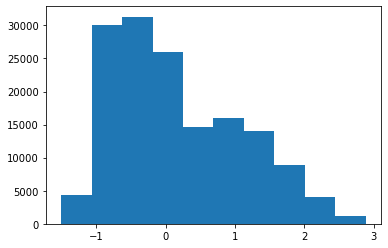

In [24]:
plt.hist(data[plot_image, :, :, :].cpu().detach().numpy().flatten())

(array([ 6183., 18212., 18743., 27188., 18572., 15837., 18870., 14926.,
         8511.,  3486.]),
 array([-1.0106246 , -0.807294  , -0.6039634 , -0.40063277, -0.19730215,
         0.00602847,  0.2093591 ,  0.41268972,  0.6160203 ,  0.81935096,
         1.0226816 ], dtype=float32),
 <a list of 10 Patch objects>)

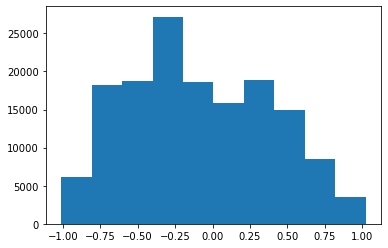

In [25]:
plt.hist(test_output[plot_image, :, :, :].cpu().detach().numpy().flatten())

In [26]:
torch.mean(test_output[:,0,:,:])

tensor(0.1851, device='cuda:1', grad_fn=<MeanBackward0>)

In [27]:
torch.mean(test_output[:,1,:,:])

tensor(-0.0149, device='cuda:1', grad_fn=<MeanBackward0>)

In [28]:
torch.mean(test_output[:,2,:,:])

tensor(-0.0742, device='cuda:1', grad_fn=<MeanBackward0>)

In [29]:
torch.mean(data[:,0,:,:])

tensor(0.6245, device='cuda:1')

In [30]:
torch.mean(data[:,1,:,:])

tensor(0.2048, device='cuda:1')

In [31]:
torch.mean(data[:,1,:,:])

tensor(0.2048, device='cuda:1')

In [35]:
np.mean((test_output - data).detach().cpu().numpy()[:,0,:,:])

-0.4393439

In [36]:
np.mean((test_output - data).detach().cpu().numpy()[:,1,:,:])

-0.21970952

In [37]:
np.mean((test_output - data).detach().cpu().numpy()[:,2,:,:])

-0.258049

In [38]:
np.mean((test_output - data).cpu().detach().numpy())

-0.3057009

In [39]:
np.mean(np.power((test_output - data).cpu().detach().numpy(), 2))

0.72291917

(array([3.50000e+02, 3.25100e+03, 2.71720e+04, 9.42300e+04, 1.73947e+05,
        3.10590e+05, 1.63170e+05, 2.74380e+04, 2.56700e+03, 1.01000e+02]),
 array([-4.0459247 , -3.319411  , -2.5928974 , -1.8663839 , -1.1398704 ,
        -0.41335678,  0.31315678,  1.0396703 ,  1.766184  ,  2.4926975 ,
         3.219211  ], dtype=float32),
 <a list of 10 Patch objects>)

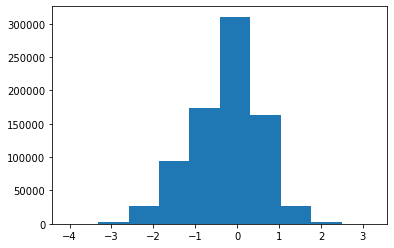

In [41]:
plt.hist((test_output - data).detach().cpu().numpy()[:,2,:,:].flatten())

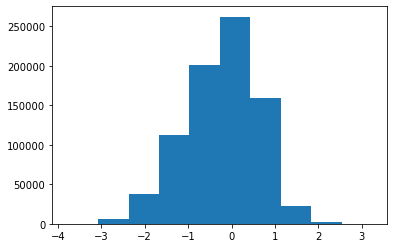

In [43]:
plt.hist((test_output - data).detach().cpu().numpy()[:,1,:,:].flatten());

(array([6.74000e+02, 9.19200e+03, 4.83720e+04, 1.37380e+05, 2.66461e+05,
        2.52947e+05, 7.54210e+04, 1.10250e+04, 1.30200e+03, 4.20000e+01]),
 array([-3.4238567 , -2.7913926 , -2.1589284 , -1.5264642 , -0.89400005,
        -0.26153588,  0.3709283 ,  1.0033925 ,  1.6358566 ,  2.2683208 ,
         2.900785  ], dtype=float32),
 <a list of 10 Patch objects>)

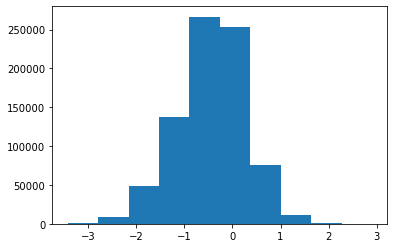

In [44]:
plt.hist((test_output - data).detach().cpu().numpy()[:,0,:,:].flatten())

In [45]:
test_output_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0).numpy()

array([[[0.39432952, 0.4084809 , 0.39417177],
        [0.39598325, 0.40991765, 0.396675  ],
        [0.41272426, 0.42679325, 0.41829467],
        ...,
        [0.31551498, 0.3314867 , 0.3060067 ],
        [0.32079005, 0.33457687, 0.30921015],
        [0.3216532 , 0.3356929 , 0.3102236 ]],

       [[0.39704326, 0.41030225, 0.39724463],
        [0.39843225, 0.4111037 , 0.39796886],
        [0.41462782, 0.42852995, 0.42042258],
        ...,
        [0.31563625, 0.3305856 , 0.30534625],
        [0.32129052, 0.334225  , 0.30987614],
        [0.32198995, 0.3348163 , 0.31056798]],

       [[0.41006613, 0.42749467, 0.41683638],
        [0.41014874, 0.42777178, 0.41678345],
        [0.41316965, 0.43185896, 0.42518926],
        ...,
        [0.32343987, 0.32969326, 0.29286695],
        [0.32590488, 0.33761472, 0.3080101 ],
        [0.32733402, 0.33814985, 0.30909687]],

       ...,

       [[0.45754248, 0.47002283, 0.47089824],
        [0.46099272, 0.47369924, 0.4750863 ],
        [0.4623337 , 0

In [47]:
data_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0).numpy()

array([[[0.36470586, 0.23921569, 0.20392157],
        [0.36470586, 0.23921569, 0.20392157],
        [0.38039213, 0.25490198, 0.20392157],
        ...,
        [0.29411763, 0.19607843, 0.16470589],
        [0.28627452, 0.18039216, 0.14901961],
        [0.28627452, 0.18039216, 0.13333336]],

       [[0.36470586, 0.23921569, 0.20392157],
        [0.36470586, 0.23921569, 0.20392157],
        [0.38039213, 0.25490198, 0.20392157],
        ...,
        [0.28627452, 0.16470589, 0.14901961],
        [0.28627452, 0.18039216, 0.14901961],
        [0.28627452, 0.18039216, 0.14901961]],

       [[0.36470586, 0.23921569, 0.20392157],
        [0.36470586, 0.23921569, 0.20392157],
        [0.38039213, 0.25490198, 0.20392157],
        ...,
        [0.25882354, 0.1490196 , 0.11764705],
        [0.29411763, 0.19215687, 0.14117648],
        [0.29411763, 0.19215687, 0.14117648]],

       ...,

       [[0.7647059 , 0.7607843 , 0.76078427],
        [0.44313723, 0.4117647 , 0.41176468],
        [0.32156864, 0

In [25]:
plot_image = 3

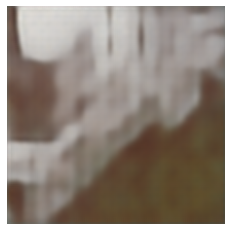

In [26]:
plt.imshow(test_output_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0))
plt.axis('off');

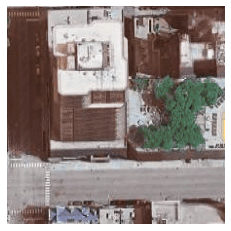

In [24]:
plt.imshow(data_orig[plot_image,:,:,:].cpu().detach().permute(1, 2, 0));
plt.axis('off');

In [ ]:
model

In [ ]:
plt.hist(data.detach().numpy()[:,0,:,:].flatten())